## https://www.kaggle.com/c/ieee-fraud-detection

# IEEE-CIS Fraud Detection
## Can you detect fraud from customer transactions?

In [51]:
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

# for modeling
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# (Data Exploring in 'Kaggle_IEEE_Fraud_Detection_EDA')

# Import Data in the same ways as explained in the EDA notebook

In [2]:
train_id = pd.read_csv('ieee-fraud-detection/train_identity.csv')

In [3]:
train_trans = pd.read_csv('ieee-fraud-detection/train_transaction.csv')

In [4]:
test_id = pd.read_csv('ieee-fraud-detection/test_identity.csv')

In [5]:
test_trans = pd.read_csv('ieee-fraud-detection/test_transaction.csv')

In [ ]:
df = train_trans.merge(train_id, how='left', on='TransactionID')
df_test = test_trans.merge(test_id, how='left', on='TransactionID')
del train_trans, train_id, test_trans, test_id

In [9]:
def change_dtype(df,type_to_change_dict):
    for feature in type_to_change_dict:
        df[feature] = df[feature].astype(type_to_change_dict[feature])

In [ ]:
del train

In [10]:
#reduce memory use
# float32, int32 is enough to hold these data and to get sum and mean (checked)
for col in df.columns:
    if df[col].dtype == np.float64:
        change_dtype(df, {col:np.float32})
    elif df[col].dtype == np.int64:
        change_dtype(df, {col:np.int32})

for col in df_test.columns:
    if df_test[col].dtype == np.float64:
        change_dtype(df_test, {col:np.float32})
    elif df_test[col].dtype == np.int64:
        change_dtype(df_test, {col:np.int32})
        
# only binary values
df['isFraud']=df['isFraud'].astype(np.int8)

In [16]:
df.shape

(590540, 434)

In [14]:
# def memory_64_to_32(df,df_test = pd.DataFrame()):
# #reduce memory use
# # float32, int32 is enough to hold these data and to get sum and mean (checked)
#     for col in tqdm(df.columns):
#         if df[col].dtype == np.float64:
#             change_dtype(df, {col:np.float32})
#         elif df[col].dtype == np.int64:
#             change_dtype(df, {col:np.int32})

#     for col in tqdm(df_test.columns):
#         if df_test[col].dtype == np.float64:
#             change_dtype(df_test, {col:np.float32})
#         elif df_test[col].dtype == np.int64:
#             change_dtype(df_test, {col:np.int32})

#     # only binary values
#     if 'isFraud' in df.columns:
#         df['isFraud']=df['isFraud'].astype(np.int8)

In [215]:
# memory_64_to_32(df1,df1_test)


100%|██████████| 289/289 [00:00<00:00, 14655.82it/s]

 61%|██████    | 175/288 [00:15<00:34,  3.29it/s]

KeyboardInterrupt: 

# Data preprocessing

## To get a baseline model, let's do basic data preprocessing

- #### Drop the features whose missing data are more than 50% 
- #### One-hot-encoding for object features
- #### Fill missing values with the mean of each feature

In [11]:
def threshold_null_cols(df,threshold = 0.5):
    null_cols = df.isnull().sum(axis=0)/len(df) > threshold
    return list(null_cols[null_cols].keys())

def drop_cols(df,col_name_list):
    df1 = df.drop(col_name_list,axis='columns')
    return df1

def one_hot(df, dummy_na = False):
    df1 = pd.get_dummies(df, dummy_na=dummy_na)
    return df1

def fill_na(df1,mean_mode = 'mean'):
    if mean_mode == 'mode':
        df1.fillna(df1.mode(),inplace = True)
    df1.fillna(df1.mean(),inplace = True)

In [14]:
df1 = one_hot( drop_cols(df, threshold_null_cols(df)  )  )

In [26]:
fill_na(df1)

In [15]:
df1.shape

(590540, 294)

# Baseline Model

## Let's get a baseline model with df1

- ### I'll train with Random Forest Classifier and get a score using validation set (train:val = 0.8:0.2)

In [20]:
def make_train_val(df, val_size = 0.2):
    # Split the data into training and testing sets
    train, val = train_test_split(df, test_size = val_size)
    assert train.shape[0]+val.shape[0] == df.shape[0], 'data wrong'
    assert train.shape[1] == val.shape[1], 'data wrong'
    return train, val

def make_XY(df, target, drop_cols = []):
    dataX, dataY = df.drop([target]+drop_cols, axis=1), df[target]
    return dataX, dataY

In [27]:
target = 'isFraud'
train, val = make_train_val(df1)
trainX, trainY = make_XY(train,target)
valX, valY = make_XY(val,target)
del train, val

In [29]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100,  max_depth=10, n_jobs=-1)
# Train with the training data
random_forest.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
# Function showing scores of the model on a validation set
def output_auc(model, data_X, data_Y, return_auc=False):
    ## Results on val data:
    predProba = model.predict_proba(data_X)
    # Make predictions on the validation data
    pred = model.predict(data_X)

    ## Accuracy:
    print("accuracy: ", accuracy_score(pred, data_Y))

    # compute the AUC score:
    auc_score = roc_auc_score(data_Y, predProba[:,1])
    print("AUC score: ", auc_score)

    # confusion matrix:
    print("confusion matrix:\n", confusion_matrix(pred, data_Y),"\n")
        
    if return_auc:
        return auc_score

In [32]:
output_auc(random_forest, valX, valY)

accuracy:  0.9724320113794155
AUC score:  0.8783128564159979
confusion matrix:
 [[113825   3176]
 [    80   1027]] 



- ### Our baseline score is 0.878. Let's improve this with further feature engineering.

# Feature Engineering

In [34]:
del df1

- ### Instead of dropping features with more than half null data, let's drop the feature if missing on Fraud data is more than 70%

In [39]:
def fraud_threshold_null_cols(df,target='isFraud',threshold = 0.5):
    null_cols = df[df[target]==1].isnull().sum(axis=0)/len(df[df[target]==1]) > threshold
    return list(null_cols[null_cols].keys())

In [40]:
null_cols = fraud_threshold_null_cols(df,target, threshold=0.7)
#cols with null data ratio >threshold in Fraud data

In [41]:
len(null_cols)

80

- ### Let's check whether the TransAmt has decimal is correlated to Fraud
- ### As explained in EDA, let's dig in 'TransactionDT' more. I put what hours, days and months the transaction happened

In [44]:
def Amt_decimal_bool(df1, TransAmt = 'TransactionAmt'):
    df1['TransactionAmt_decimal'] = df1[TransAmt].apply(lambda x: 1 if x - np.floor(x) >0 else 0)

def trans_time(df1,trans_day_cycle = True, trans_month_cycle = True, trans_time_cycle = True,\
              del_dayofweek = True, del_month = True, del_DT = True):
    df1['Transaction_day_of_week'] = np.floor((df1['TransactionDT'] / (3600 * 24)) % 7)
    df1['Transaction_month'] = np.floor((df1['TransactionDT'] / (3600 * 24 *30)) % 12)
    df1['Transaction_time'] = np.floor((df1['TransactionDT'] / (3600)) % 24)
    if trans_day_cycle:
        df1['Transaction_day_cycle'] = ((df1['TransactionDT'] / (3600 * 24)) % 7).apply(lambda x:np.sin(2*np.pi*x /7 ))
    if trans_month_cycle:
        df1['Transaction_month_cycle'] = ((df1['TransactionDT'] / (3600 * 24 * 30)) % 12).apply(lambda x:np.sin(2*np.pi*x /12 ))
    if trans_time_cycle:
        df1['Transaction_time_cycle'] = ((df1['TransactionDT'] / (3600)) % 24).apply(lambda x:np.sin(2*np.pi*x /24 ))
    if del_dayofweek:
        df1.drop('Transaction_day_of_week',axis='columns',inplace = True)
    if del_month:
        df1.drop('Transaction_month',axis='columns',inplace = True)
    if del_DT:
        df1.drop('TransactionDT',axis='columns',inplace = True)

def data_preprocessing(df,cols_to_pick = [], cols_to_del = []):
    df = drop_cols(df,cols_to_del)
    df1 = one_hot(df, dummy_na=True)
#    fill_na(df1,'mean')
    Amt_decimal_bool(df1)
    trans_time(df1)
    if len(cols_to_pick):
        if set(cols_to_pick)-set(df1.columns):
            print(f"{list(set(cols_to_pick)-set(df1.columns))} is not in index")
            cols_to_pick = [col for col in cols_to_pick if col in df1.columns ]
        df1 = df1[cols_to_pick]
    return df1

In [45]:
df1 = data_preprocessing(df,cols_to_del = null_cols)

In [243]:
#matching names ('id-01' format in test, 'id_01' format in train)
df_test.rename(index=str, columns={f"id-{n+1:02d}": f"id_{n+1:02d}" for n in range(38) }, inplace = True)

In [244]:
df1_test = data_preprocessing(df_test,cols_to_del = null_cols)

In [40]:
cols_both = [col for col in df1.columns if col in df1_test.columns]

In [41]:
df1 = df1[cols_both]
df1_test = df1_test[cols_both]

- ## Missing values are filled with mean of each feature
- ### Test set missing values are filled with the mean of train set

In [52]:
def imputer(train,na_col_list, val = pd.DataFrame(), test = pd.DataFrame()):
    df_na_cols = train[na_col_list]
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy = True)
    imp_mean.fit(df_na_cols)
    train[na_col_list] = imp_mean.transform(df_na_cols)
    if len(val):
        val[na_col_list] = imp_mean.transform(val[na_col_list])
    if len(test):
        test[na_col_list] = imp_mean.transform(test[na_col_list])

In [53]:
na_col_list = df1.keys()[pd.concat([df1, df1_test],axis =0).isnull().any()]

imputer(df1, na_col_list,  test = df1_test)

In [ ]:
df1[target] = df[target]

- ## Since only 3.5% are Fraud, I check correlation of each feature with target('isFraud') with balanced sample.
- ### Average correlations over 20 samples and get features with avg_corr > 0.01

In [54]:
def large_cor_cols_from_bal_data(df1,target,threshold,num_itr_to_avg, no_cor_cols = [target], verbose = False):
    fraud_raw = df1[df1[target] == 1]
    safe_raw = df1[df1[target] == 0]
    percentage = len(fraud_raw)/float(len(safe_raw))
    cor = {}
    for i in range(num_itr_to_avg):
        safe = safe_raw.sample(frac = percentage)
        df1_bal = safe.append(fraud_raw)
        cor[i] = abs(df1_bal.drop(no_cor_cols, axis = 1).apply(lambda x: x.corr(df1_bal['isFraud'])))
        if i == 0:
            cor_df = cor[i]
        else:
            cor_df = pd.concat([cor_df, cor[i]], axis = 1, sort = False) 
        
    cor_sort = cor_df.mean(axis=1).sort_values(ascending=False)

    lg_cor = cor_sort[cor_sort >= threshold]
    if verbose:
        print(lg_cor.to_string())
        print(f'------ threshold = {threshold} ------')
        print(cor_sort[cor_sort < threshold].to_string())
    lg_cor_cols =  list(lg_cor.index.values)

    return lg_cor_cols

In [55]:
lg_cor_cols = large_cor_cols_from_bal_data(df1,target,threshold=0.01,num_itr_to_avg=20)

In [56]:
df1 = df1[[target]+lg_cor_cols]
df1_test = df1_test[lg_cor_cols]

# First Modeling to get important features

In [57]:
rs = ShuffleSplit(n_splits=1, test_size=.25)

In [58]:
lgb_clf = lgb.LGBMClassifier(num_leaves = 500, n_estimators=100,
                        n_jobs=-1,
                        max_depth=-1,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        min_data_in_leaf = 0,
                        min_split_gain = 0,
                        subsample_for_bin = 200000)

In [63]:
def lgb_training(df1, target = 'isFraud'):
    df1X = df1.drop(target, axis=1)
    feature_names = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in list(df1X.columns)]
    for train_index, val_index in rs.split(df1, df1[target]):
        trainX, trainY = df1X.iloc[train_index], df1[target].iloc[train_index]

    #     trainY.reset_index(drop = True, inplace = True)
    #     trainX.reset_index(drop = True, inplace = True)
    #     idx_for_1 = np.where(trainY == 1)[0]
    #     idx_for_0 = list(  set(range(trainY.shape[0]))-set(idx_for_1)  )
    #     sample_idx_for_0 = random.choices(idx_for_0,k = (trainY == 1).sum())
    #     sample_idx = list(idx_for_1) + sample_idx_for_0
    #     sample_idx.sort()

    #     trainX = trainX.iloc[sample_idx]
    #     trainY = trainY.iloc[sample_idx]

        valX, valY = df1X.iloc[val_index], df1[target].iloc[val_index]
        lgb_clf.fit(trainX, trainY, feature_name = feature_names)
        output_auc(lgb_clf, valX, valY)

In [66]:
lgb_training(df1)

accuracy:  0.9818674433569275
AUC score:  0.9496378173895632
confusion matrix:
 [[141971   2295]
 [   382   2987]] 



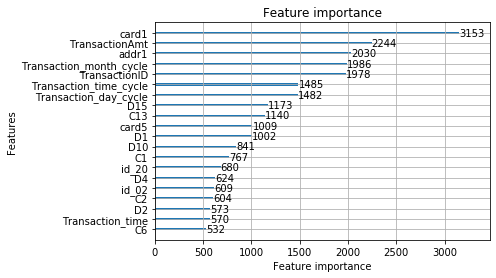

In [69]:
lgb.plot_importance(lgb_clf,max_num_features=20 , importance_type = 'split')

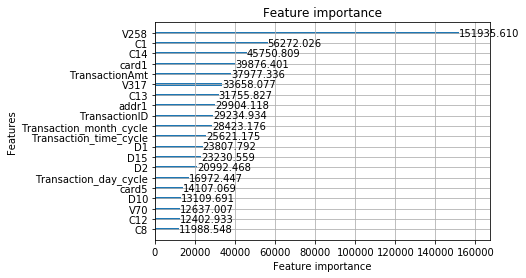

In [70]:
lgb.plot_importance(lgb_clf,max_num_features=20 , importance_type = 'gain')

- ### Keep only top 100 important features in 'split' and also in 'gain', and take the union of those

In [1771]:
impt_ftr_gain_idx = np.argsort(lgbm_clf.feature_importance(importance_type='gain'))[::-1][:100]

In [1774]:
impt_ftr_split_idx = np.argsort(lgbm_clf.feature_importance(importance_type='split'))[::-1][0:100]

In [1775]:
important_feature_idx = np.union1d(impt_ftr_gain_idx,impt_ftr_split_idx)

In [1776]:
original_feature_names = list(df1_impt_add.columns)

In [1777]:
important_features = list(itemgetter(*important_feature_idx)(original_feature_names)) 

In [ ]:
df1_impt = df1[important_features]
df1_test_impt = df1_test[important_features]

# Additional Feature Engineering

- ### Combining a pair of features and Label-encoding
- ### Count values of some features in whole dataset (train+test) 
- ### Count null values each row

In [894]:
def add_features(train, test):
    df_add = pd.DataFrame()
    df_test_add = pd.DataFrame()
    impt_cols = train.columns
    for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                    'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

        f1, f2 = feature.split('__')
        if (f1 in impt_cols) & (f2 in impt_cols):
            df_add[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
            df_test_add[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

            le = LabelEncoder()
            le.fit(list(df_add[feature].astype(str).values) + list(df_test_add[feature].astype(str).values))
            df_add[feature] = le.transform(list(df_add[feature].astype(str).values))
            df_test_add[feature] = le.transform(list(df_test_add[feature].astype(str).values))

    for feature in ['id_34', 'id_36', 'card1']:
        if feature in impt_cols:
            # Count encoded for both train and test
            df_add[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
            df_test_add[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

    for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
        if feature in impt_cols:
            # Count encoded separately for train and test
            df_add[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
            df_test_add[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))
    
    df_add['nulls'] = df.isnull().sum(axis=1)
    df_test_add['nulls'] = df_test.isnull().sum(axis=1)
    
    return df_add, df_test_add

In [898]:
df1_add, df1_test_add = add_features(df,df_test)

In [1128]:
df1_impt = pd.concat([df1_impt, df1_add], axis = 1)
df1_test_impt = pd.concat([df1_test_impt, df1_test_add], axis = 1)

## Combining TransAmt with features

- ### As explained in EDA some value in each feature shows more TransAmt when Fraud than NoFraud
- ### TransAmt grouped by these categorical values of features can improve the model

In [1611]:
def add_feature_TransAmt(df_original, feature, others_threshold = 5000):
    play_df = df_original[[feature]].copy()
    play_df.loc[play_df[feature].isin(play_df[feature].value_counts(dropna=False)[play_df[feature].value_counts(dropna=False) <= others_threshold ].index)\
                , feature] = "Others"
    play_idx = play_df[feature].value_counts(dropna=False).index
    for idx in play_idx:
        play_df[f'{feature}_{idx}_TransAmt'] = df_original['TransactionAmt'].where(play_df[feature].astype(str) == str(idx),0)
    return play_df

def add_feature_TransAmt_lg_cor(df_original, feature, target = 'isFraud', 
                                df_test = pd.DataFrame(), verbose = False, cor_threshold = 0.01, others_threshold = 5000):
    play_df = add_feature_TransAmt(df_original, feature, others_threshold = others_threshold)
    
    play_df[target] = df_original[target].copy()
    play_lg_cor_cols = large_cor_cols_from_bal_data(play_df, target, cor_threshold, num_itr_to_avg=20,
                                                    no_cor_cols= ['isFraud',feature], verbose= verbose)
    if len(df_test):
        play_df_test = add_feature_TransAmt(df_test, feature, others_threshold = others_threshold)
        if set(play_lg_cor_cols).issubset(set(play_df_test.columns)):
            return play_df[play_lg_cor_cols], play_df_test[play_lg_cor_cols]
        else:
            diff_cols = {set(play_lg_cor_cols)-set(play_df_test.columns)}
            print(f'{diff_cols} is not in test data')
            for i in diff_cols:
                play_lg_cor_cols.remove(i)
            return play_df[play_lg_cor_cols], play_df_test[play_lg_cor_cols]
    else:
        return play_df[play_lg_cor_cols]

def concat_add_feature_dfs(df_original, feature_list, target = 'isFraud', df_test = pd.DataFrame(), verbose = False, cor_threshold = 0.01, others_threshold = 5000):
    df_more_feature_total = pd.DataFrame()
    if not len(df_test):
        for feature in feature_list:
            df_more_feature = add_feature_TransAmt_lg_cor(df_original, feature, target = 'isFraud', df_test = df_test  , verbose = verbose ,  cor_threshold = cor_threshold , others_threshold =  others_threshold)
            df_more_feature_total = pd.concat([df_more_feature_total, df_more_feature], axis = 1, sort = False)
            if verbose:
                print('')
        return df_more_feature_total
    elif len(df_test):
        df_test_more_feature_total = pd.DataFrame()
        for feature in feature_list:
            df_more_feature, df_test_more_feature = add_feature_TransAmt_lg_cor(df_original, feature, target = 'isFraud',
                                                                                df_test = df_test , verbose=verbose, 
                                                          cor_threshold = cor_threshold , others_threshold =  others_threshold)
            df_more_feature_total = pd.concat([df_more_feature_total, df_more_feature], axis = 1, sort = False)
            df_test_more_feature_total = pd.concat([df_test_more_feature_total, df_test_more_feature], axis = 1, sort = False)
            if verbose:
                print('')
        return df_more_feature_total, df_test_more_feature_total

In [1631]:
df_more_feature, df_test_more_feature = concat_add_feature_dfs(df, ['ProductCD','card4'], df_test = df_test,
                                         verbose = False, cor_threshold=0.03, others_threshold = 5)

df_more_feature_M, df_test_more_feature_M = concat_add_feature_dfs(df, [f'M{i+1}' for i in range(9)], df_test = df_test, verbose = False, cor_threshold=0.1, others_threshold = 5)

df_more_feature_addr1, df_test_more_feature_addr1 = concat_add_feature_dfs(df, ['addr1'], df_test = df_test, verbose = False, cor_threshold=0.1, others_threshold = 5000)

df_more_feature_addr2, df_test_more_feature_addr2 = concat_add_feature_dfs(df, ['addr2'], df_test = df_test, verbose = False, cor_threshold=0.1, others_threshold = 50)

df_more_feature_card3, df_test_more_feature_card3 = concat_add_feature_dfs(df, ['card3'], df_test = df_test, verbose = False, cor_threshold=0.1, others_threshold = 500)

df_more_feature = pd.concat([df_more_feature, df_more_feature_addr1, df_more_feature_addr2, df_more_feature_card3, df_more_feature_M], axis =1)

df_test_more_feature = pd.concat([df_test_more_feature, df_test_more_feature_addr1, df_test_more_feature_addr2, df_test_more_feature_card3, df_test_more_feature_M], axis =1)

del df_more_feature_M, df_test_more_feature_M, df_more_feature_addr1, df_test_more_feature_addr1, df_more_feature_addr2, df_test_more_feature_addr2, df_more_feature_card3, df_test_more_feature_card3

In [857]:
df1_impt = pd.concat([df1_impt,df_more_feature], axis =1, sort=False)
df1_test_impt = pd.concat([df1_test_impt,df_test_more_feature], axis =1, sort=False)

# LightGBM Modeling

## For final modeling I use LGBM

In [ ]:
rs = ShuffleSplit(n_splits=1, test_size=.25)

In [1782]:
def train_val_split(df1_impt_add, target = 'isFraud'):
#    feature_names = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in list(df1_impt_add.columns)]
    i = 0
    for train_index, val_index in rs.split(df1_impt_add, df[target]):
        trainX, trainY = df1_impt_add.iloc[train_index], df[target].iloc[train_index]

        #     trainY.reset_index(drop = True, inplace = True)
        #     trainX.reset_index(drop = True, inplace = True)
        #     idx_for_1 = np.where(trainY == 1)[0]
        #     idx_for_0 = list(  set(range(trainY.shape[0]))-set(idx_for_1)  )
        #     sample_idx_for_0 = random.choices(idx_for_0,k = (trainY == 1).sum())
        #     sample_idx = list(idx_for_1) + sample_idx_for_0
        #     sample_idx.sort()

        #     trainX = trainX.iloc[sample_idx]
        #     trainY = trainY.iloc[sample_idx]

        valX, valY = df1_impt_add.iloc[val_index], df[target].iloc[val_index]
        i += 1
        print(f'split {i}')
    
    return trainX, trainY, valX, valY

In [ ]:
trainX, trainY, valX, valY = train_val_split(df1_impt, target = 'isFraud')

In [1736]:
dtrain = lgb.Dataset(trainX, label=trainY)
dvalid = lgb.Dataset(valX, label=valY)

In [1716]:
# optimized parameters
params = {'num_leaves': 546,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.1797454081646243,
          'bagging_fraction': 0.2181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.005883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3299927210061127,
          'reg_lambda': 0.3885237330340494,
          'random_state': 42,
}

In [1717]:
lgbm_clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.949815	valid_1's auc: 0.929437
[400]	training's auc: 0.966843	valid_1's auc: 0.94217
[600]	training's auc: 0.979822	valid_1's auc: 0.95179
[800]	training's auc: 0.987616	valid_1's auc: 0.958306
[1000]	training's auc: 0.992515	valid_1's auc: 0.962881
[1200]	training's auc: 0.995548	valid_1's auc: 0.965863
[1400]	training's auc: 0.997364	valid_1's auc: 0.968024
[1600]	training's auc: 0.99845	valid_1's auc: 0.969617
[1800]	training's auc: 0.999084	valid_1's auc: 0.970843
[2000]	training's auc: 0.999452	valid_1's auc: 0.971744
[2200]	training's auc: 0.999677	valid_1's auc: 0.972447
[2400]	training's auc: 0.999813	valid_1's auc: 0.97306
[2600]	training's auc: 0.999893	valid_1's auc: 0.973502
[2800]	training's auc: 0.999939	valid_1's auc: 0.973844
[3000]	training's auc: 0.999966	valid_1's auc: 0.974097
[3200]	training's auc: 0.999982	valid_1's auc: 0.974346
[3400]	training's auc: 0.999991	valid_1's auc: 0.9

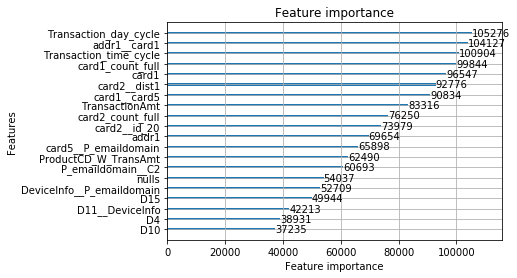

In [1723]:
lgb.plot_importance(lgbm_clf,max_num_features=20 , importance_type = 'split')

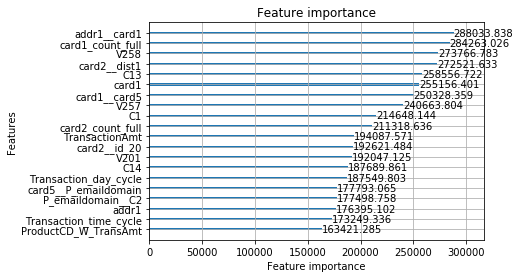

In [1724]:
lgb.plot_importance(lgbm_clf,max_num_features=20 , importance_type = 'gain')

In [1764]:
def feature_impt_list(lgbm_clf, df_cols, importance_type = 'split'):
    feature_impt = lgbm_clf.feature_importance(importance_type = importance_type)
    impt_feature_names = itemgetter(*np.argsort(feature_impt)[::-1])(df_cols)
    impt_feature_score = itemgetter(*np.argsort(feature_impt)[::-1])(feature_impt)
    if importance_type == 'split':
        for name, score in zip(impt_feature_names, impt_feature_score):
            print(f'{name:30s} : {score:8d}')
    if importance_type == 'gain':
        for name, score in zip(impt_feature_names, impt_feature_score):
            print(f'{name:30s} : {score:10.2f}')

In [1765]:
feature_impt_list(lgbm_clf, df1_impt_add.columns, importance_type = 'split')

Transaction_day_cycle          :   105276
addr1__card1                   :   104127
Transaction_time_cycle         :   100904
card1_count_full               :    99844
card1                          :    96547
card2__dist1                   :    92776
card1__card5                   :    90834
TransactionAmt                 :    83316
card2_count_full               :    76250
card2__id_20                   :    73979
addr1                          :    69654
card5__P_emaildomain           :    65898
ProductCD_W_TransAmt           :    62490
P_emaildomain__C2              :    60693
nulls                          :    54037
DeviceInfo__P_emaildomain      :    52709
D15                            :    49944
D11__DeviceInfo                :    42213
D4                             :    38931
D10                            :    37235
D1                             :    35201
id_02                          :    32679
M6_nan_TransAmt                :    32330
D2                             :  

In [1766]:
feature_impt_list(lgbm_clf, df1_impt_add.columns, importance_type = 'gain')

addr1__card1                   :  288033.84
card1_count_full               :  284263.03
V258                           :  273766.78
card2__dist1                   :  272521.63
C13                            :  258556.72
card1                          :  255156.40
card1__card5                   :  250328.36
V257                           :  240663.80
C1                             :  214648.14
card2_count_full               :  211318.64
TransactionAmt                 :  194087.57
card2__id_20                   :  192621.48
V201                           :  192047.13
C14                            :  187689.86
Transaction_day_cycle          :  187549.80
card5__P_emaildomain           :  177793.06
P_emaildomain__C2              :  177498.76
addr1                          :  176395.10
Transaction_time_cycle         :  173249.34
ProductCD_W_TransAmt           :  163421.28
D15                            :  148873.64
C8                             :  147309.29
D2                             :

## Stratified K Fold 

In [918]:
skf = StratifiedKFold(n_splits=5, shuffle = True)

In [2995]:
auc_scores = []
for train_index, val_index in skf.split(df1_impt_add, df[target]):
    trainX, trainY = df1_impt_add.iloc[train_index], df[target].iloc[train_index]
    valX, valY = df1_impt_add.iloc[val_index], df[target].iloc[val_index]   
    
    dtrain = lgb.Dataset(trainX, label=trainY)
    dvalid = lgb.Dataset(valX, label=valY)

    
    lgbm_clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=2000, early_stopping_rounds=500)
    auc_scores.append(list(lgbm_clf.best_score['valid_1'].values())[0])
print(f"Mean AUC score: {np.mean(auc_scores)}\n")

Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.999267	valid_1's auc: 0.971211
[4000]	training's auc: 0.999998	valid_1's auc: 0.974413
Early stopping, best iteration is:
[4832]	training's auc: 1	valid_1's auc: 0.974535
Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.999334	valid_1's auc: 0.971276
[4000]	training's auc: 0.999999	valid_1's auc: 0.974626
Early stopping, best iteration is:
[4528]	training's auc: 1	valid_1's auc: 0.974753
Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.999281	valid_1's auc: 0.974602
[4000]	training's auc: 0.999997	valid_1's auc: 0.977486
Early stopping, best iteration is:
[5478]	training's auc: 1	valid_1's auc: 0.977748
Training until validation scores don't improve for 500 rounds
[2000]	training's auc: 0.999298	valid_1's auc: 0.973541
[4000]	training's auc: 0.999998	valid_1's auc: 0.976157
Early stopping, best iteration is:
[4332]	training's

- # The mean AUC score: 0.97552
- # It improved the basic model score 0.8783 by 11.1%

# Submission

In [1726]:
test_predic = lgbm_clf.predict(df1_test_impt_add)

In [1787]:
#test_predic = lgbm_clf.predict(df1_test_impt_add[important_features])

In [1683]:
#submission = pd.DataFrame({'TransactionID': df_test['TransactionID'].values, 'isFraud': test_predic[:,1]})

In [1788]:
submission = pd.DataFrame({'TransactionID': df_test['TransactionID'].values, 'isFraud': test_predic})

In [1729]:
submission

,TransactionID,isFraud
0,3663549,0.000196
1,3663550,0.000209
2,3663551,0.000207
3,3663552,0.000250
4,3663553,0.000096
...,...,...
506686,4170235,0.000648
506687,4170236,0.001740
506688,4170237,0.005191
506689,4170238,0.000826


In [1789]:
submission.to_csv('submission.csv',index=False)